In [1]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from os.path import join as pjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn.glm.contrasts import compute_contrast
# define path
beta_path = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/derivatives/beta'
melodic_path= '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/derivatives/melodic/'
fmriprep_path = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/derivatives/fmriprep'
ciftify_path = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/derivatives/ciftify'
nifti_path = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/nifti'
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
beh_path = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/behavior/LOCdata'
result_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/data_paper/result'

# define plot utils
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# generate surface map for tSNR
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    if len(data.shape) > 1:
        ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    else:
        ex_cii.header.get_index_map(0).number_of_series_points = 1
        data = data[np.newaxis, :]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [ ]:
# load design and perform GLM
# load nifti events and define the design matrix
# prepare params
n_event = 10
n_tr = 150
tr = 2
frame_times = np.arange(n_tr) * tr
sub_names = sorted(os.listdir(beh_path))

beta_sum = np.zeros((len(sub_names), 10, 91282))
beta_sum_path = pjoin(result_path, 'functional_localizer', f'sub-all_localizer-beta_s2.npy')
for sub_id, sub_beh_name in enumerate(sub_names[:1]):
    sub_name = 'sub-' + sub_beh_name.split('_')[0][-2:]
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_localizer-beta_s2.npy')
    if not os.path.exists(beta_sub_path):
        beta_sub = np.zeros((1, 10, 91282))
        sub_name = 'sub-' + sub_beh_name.split('_')[0][-2:]
        fLoc_path = pjoin(beh_path, sub_beh_name, 'fLoc')
        sess_names = sorted([i for i in os.listdir(fLoc_path) if os.path.isdir(pjoin(fLoc_path, i))])
        # start runnning
        for sess_id, sess_name in enumerate(sess_names):
            sess_path = pjoin(fLoc_path, sess_name)
            run_names = sorted([i for i in os.listdir(sess_path) if i.endswith('.par')])
            for run_id, run_name in enumerate(run_names[:1]):
                run_path = pjoin(sess_path, run_name)
                run_par = pd.read_csv(run_path, sep=' ', header=None)
                run_par = run_par.drop(run_par.columns[1], axis=1).dropna(axis=1)
                # fit design matrix based on trial onset time
                onset = run_par.iloc[:, 0].to_numpy()
                category_idx = run_par.iloc[:, 1].to_numpy()
                category_names = run_par.iloc[:, 2]
                # detele baseline trial type
                category_loc = category_idx != 0
                onset = onset[category_loc]
                trial_type = category_names[category_loc]
                duration = np.repeat(4, trial_type.shape[0])
                # prepare design matrix
                events_used = pd.DataFrame({'trial_type':trial_type, 'onset':onset, 'duration':duration})
                design_matrix = make_first_level_design_matrix(frame_times, events_used, drift_model='polynomial', 
                                                                drift_order=3, hrf_model='spm')
                design_matrix_task = np.array(design_matrix)[:, :10]
                # load dtseries
                run_name = 'ses-Localizer%02d_task-category_run-%d'%(sess_id+1, run_id+1)
                dtseries_path = pjoin(ciftify_path, sub_name, 'MNINonLinear/Results/', run_name, 
                                    f'{run_name}_Atlas_clean.dtseries.nii')
                dtseries = nib.load(dtseries_path).get_fdata()
                # perform GLM
                reg = LinearRegression().fit(design_matrix_task, dtseries)
                r_square = reg.score(design_matrix_task, dtseries)
                beta = reg.coef_[:, :n_event].transpose(1, 0).astype(np.float32)
                print('GLM model explained variance: %.2f in %s %s'%(r_square.mean(), sub_name, run_name))
                # save beta
                beta_sub = np.concatenate((beta_sub, beta[np.newaxis, :, :]), axis=0)
        beta_sub = np.delete(beta_sub, 0, axis=0)
        beta_sub = np.mean(beta_sub, axis=0)
        np.save(beta_sub_path, beta_sub.astype(np.float32))
    else:
        beta_sub = np.load(beta_sub_path)
    print(f'Finish loading {sub_name}')
    beta_sum[sub_id] = beta_sub
beta_sum = beta_sum.mean(axis=0)
np.save(beta_sum_path, beta_sum.astype(np.float32))
    

In [ ]:
# generate specified localizer: from http://vpnl.stanford.edu/fLoc/
# order: 0: adult; 1: body; 2: car; 3: child; 4: corridor; 5: house; 6: instrument; 7: limb; 8: number; 9: word
# Character-selective regions: [word number] > [body limb child adult corridor house car instrument]
# Body-selective regions: [body limb] > [word number child adult corridor house car instrument]
# Face-selective regions: [child adult] > [word number body limb corridor house car instrument]
# Place-selective regions: [corridor house] > [word number body limb child adult car instrument]
# Object-selective regions: [car instrument] > [word number body limb child adult corridor house]

# generate surface map for
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    if len(data.shape) > 1:
        ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    else:
        ex_cii.header.get_index_map(0).number_of_series_points = 1
        data = data[np.newaxis, :]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

contrast_correspond = {'character': [8, 9], 'body': [1, 7], 'face': [0, 3], 'place': [4, 5], 'object': [2, 6]}
for contrast_name in contrast_correspond.keys():
    contrast_idx = contrast_correspond[contrast_name]
    other_idx = list(set(np.arange(10)).difference(set(contrast_idx)))
    contrast_map = beta_sum[contrast_idx].mean(axis=0) - beta_sum[other_idx].mean(axis=0)
    # save map
    save_ciftifile(contrast_map, pjoin(result_path, 'functional_localizer', f'{contrast_name}_map.dtseries.nii'))


In [4]:
# load design and perform GLM
# load nifti events and define the design matrix
# prepare params
n_event = 10
n_tr = 150
tr = 2
frame_times = np.arange(n_tr) * tr
sub_names = sorted(os.listdir(beh_path))

# one subject
# sub_names = [_ for _ in sub_names if 'sub08' in _ or 'sub04' in _]
sub_names = [_ for _ in sub_names if 'sub08' in _ ]

z_score_sum = np.zeros((len(sub_names), 5, 91282))
spatial_smooth_code = '_s4'

for sub_id, sub_beh_name in enumerate(sub_names):
    sub_name = 'sub-' + sub_beh_name.split('_')[0][-2:]
    z_score_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_localizer-z_score{spatial_smooth_code}.npy')
    # if not os.path.exists(beta_sub_path):
    z_score_sub = np.zeros((1, 5, 91282))
    sub_name = 'sub-' + sub_beh_name.split('_')[0][-2:]
    fLoc_path = pjoin(beh_path, sub_beh_name, 'fLoc')
    sess_names = sorted([i for i in os.listdir(fLoc_path) if os.path.isdir(pjoin(fLoc_path, i))])
    if '04' in sub_name: # in sub-04, the sess index corresponded wrongly between behaviour and brain data
        sess_names = sess_names[::-1]
    # start runnning
    for sess_id, sess_name in enumerate(sess_names):
        sess_path = pjoin(fLoc_path, sess_name)
        run_names = sorted([i for i in os.listdir(sess_path) if i.endswith('.par')])
        for run_id, run_name in enumerate(run_names):
            run_path = pjoin(sess_path, run_name)
            run_par = pd.read_csv(run_path, sep=' ', header=None)
            run_par = run_par.drop(run_par.columns[1], axis=1).dropna(axis=1)
            # fit design matrix based on trial onset time
            onset = run_par.iloc[:, 0].to_numpy()
            category_idx = run_par.iloc[:, 1].to_numpy()
            category_names = run_par.iloc[:, 2]
            # detele baseline trial type
            category_loc = category_idx != 0
            onset = onset[category_loc]
            trial_type = category_names[category_loc]
            duration = np.repeat(4, trial_type.shape[0])
            # prepare design matrix
            events_used = pd.DataFrame({'trial_type':trial_type, 'onset':onset, 'duration':duration})
            design_matrix = make_first_level_design_matrix(frame_times, events_used, hrf_model='spm')
            # load dtseries
            run_name = 'ses-Localizer%02d_task-category_run-%d'%(sess_id+1, run_id+1)
            dtseries_path = pjoin(ciftify_path, sub_name, 'MNINonLinear/Results/', run_name, 
                                f'{run_name}_Atlas_clean{spatial_smooth_code}.dtseries.nii')
            if not os.path.exists(dtseries_path):
                continue
            dtseries = nib.load(dtseries_path).get_fdata()
            # perform GLM
            labels, estimates = run_glm(dtseries, design_matrix.values)

            # generate specified localizer: from http://vpnl.stanford.edu/fLoc/
            # order: 0: adult; 1: body; 2: car; 3: child; 4: corridor; 5: house; 6: instrument; 7: limb; 8: number; 9: word
            # Character-selective regions: [word number] > [body limb child adult corridor house car instrument]
            # Body-selective regions: [body limb] > [word number child adult corridor house car instrument]
            # Face-selective regions: [child adult] > [word number body limb corridor house car instrument]
            # Place-selective regions: [corridor house] > [word number body limb child adult car instrument]
            # Object-selective regions: [car instrument] > [word number body limb child adult corridor house]
            
            contrast_matrix = np.eye(design_matrix.shape[1])
            basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate([i[1:] for i in design_matrix.columns])])
            contrasts = {
                'character': (
                    (basic_contrasts['word'] + basic_contrasts['number'])/2 - (basic_contrasts['body'] + basic_contrasts['limb'] + basic_contrasts['child']
                    + basic_contrasts['adult']+ basic_contrasts['corridor']+ basic_contrasts['house']+ basic_contrasts['car']+ basic_contrasts['instrument'])/8
                ), 
                'body': (
                    (basic_contrasts['body'] + basic_contrasts['limb'])/2 - (basic_contrasts['word'] + basic_contrasts['number'] + basic_contrasts['child']
                    + basic_contrasts['adult']+ basic_contrasts['corridor']+ basic_contrasts['house']+ basic_contrasts['car']+ basic_contrasts['instrument'])/8
                ), 
                'face': (
                    (basic_contrasts['child'] + basic_contrasts['adult'])/2 - (basic_contrasts['body'] + basic_contrasts['limb'] + basic_contrasts['word']
                    + basic_contrasts['number']+ basic_contrasts['corridor']+ basic_contrasts['house']+ basic_contrasts['car']+ basic_contrasts['instrument'])/8
                ), 
                'place': (
                    (basic_contrasts['corridor'] + basic_contrasts['house'])/2 - (basic_contrasts['body'] + basic_contrasts['limb'] + basic_contrasts['child']
                    + basic_contrasts['adult']+ basic_contrasts['word']+ basic_contrasts['number']+ basic_contrasts['car']+ basic_contrasts['instrument'])/8
                ), 
                'object': (
                    (basic_contrasts['car'] + basic_contrasts['instrument'])/2 - (basic_contrasts['body'] + basic_contrasts['limb'] + basic_contrasts['child']
                    + basic_contrasts['adult']+ basic_contrasts['corridor']+ basic_contrasts['house']+ basic_contrasts['word']+ basic_contrasts['number'])/8
                ),     
            }
            z_score_run = np.zeros((5, 91282))
            for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
                # compute contrast-related statistics
                contrast = compute_contrast(labels, estimates, contrast_val, contrast_type='t')
                # we present the Z-transform of the t map
                z_score_run[index] = contrast.z_score()
            # save beta
            z_score_sub = np.concatenate((z_score_sub, z_score_run[np.newaxis, :, :]), axis=0)
            print('Finish estimating in %s %s'%(sub_name, run_name))
    z_score_sub = np.delete(z_score_sub, 0, axis=0)
    z_score_sub = np.mean(z_score_sub, axis=0)
    np.save(z_score_sub_path, z_score_sub.astype(np.float32))
    print(f'Finish loading {sub_name}')
    z_score_sum[sub_id] = z_score_sub[np.newaxis, :, :]
z_score_sum = z_score_sum.mean(axis=0)
# save_ciftifile(z_score_sum, pjoin(result_path, 'functional_localizer', f'sub-all_localizer-z_score_s2.dtseries.nii'))


Finish estimating in sub-08 ses-Localizer01_task-category_run-1
Finish estimating in sub-08 ses-Localizer01_task-category_run-2
Finish estimating in sub-08 ses-Localizer01_task-category_run-3
Finish loading sub-08


In [10]:
sub_name

'sub-04'

In [3]:
z_score_sum = nib.load(pjoin(result_path, 'functional_localizer', f'sub-all_localizer-z_score_s2.dtseries.nii')).get_fdata()
contrasts = {'character':0, 'face':2}
n_contrast = 5 
z_threshold = 1.65
sub_names = sorted(os.listdir(beh_path))
for sub_id, sub_beh_name in enumerate(sub_names):
    sub_name = 'sub-' + sub_beh_name.split('_')[0][-2:]
    z_score_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_localizer-z_score.npy')
    z_score_sub = np.load(z_score_sub_path)
    # assign different ROI based on z score value 
    for contrast_name, contrast_idx in contrasts.items():
        contrast_map = np.zeros(91282)
        contrast_map[z_score_sub[contrast_idx] > z_threshold] = contrast_idx + 1
        save_ciftifile(contrast_map, pjoin(result_path, 'functional_localizer', f'{sub_name}_{contrast_name}_map.dtseries.nii'))

In [8]:
##>> scatter plot on animacy map
import nibabel as nib
import numpy as np
from os.path import join as pjoin
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
clean_code = ''#-{clean_code}
animacy_map_path = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodanalysis/inter-subject-animacymap'
file = pjoin(animacy_map_path, f'all-sub-clean_s4_t-visnet-map.dtseries.nii')
data = nib.load(file).get_fdata()

In [9]:
from sklearn.linear_model import LinearRegression
a = 2
b = 14
suba = data[a, np.where(np.isnan(data[a,:])==0)]
subb = data[b,np.where(np.isnan(data[b,:])==0)]
Lr = LinearRegression()
Lr.fit(suba.transpose(), subb.transpose())
pred = Lr.predict(suba.transpose())
beta_path = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/derivatives/beta'
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub') and int(i[-2:])!=7])
sub_names[a], sub_names[b]

('sub-03', 'sub-18')

(-6.6636024713516235,
 7.394996762275696,
 -5.852249884605408,
 6.9228708982467655)

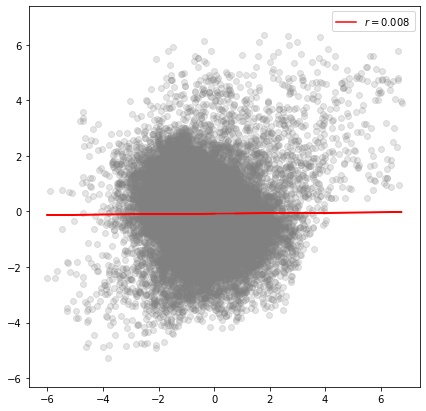

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(suba, subb, color='gray', alpha=0.2)
plt.plot(suba.transpose(), pred, color='red', label=f'$r={np.round(np.corrcoef(suba,subb)[0,1]*1000)/1000}$')
plt.legend()
plt.axis('equal')


In [7]:
np.corrcoef(suba,subb)

array([[ 1.        , -0.01122273],
       [-0.01122273,  1.        ]])

('sub-03', 'sub-18')

In [6]:
calc_input = data
if np.isnan(calc_input).sum():
    del_column = np.where(np.isnan(calc_input)==1)[1]
    calc_input = np.delete(calc_input, del_column, axis=1)
iss = np.corrcoef(calc_input)

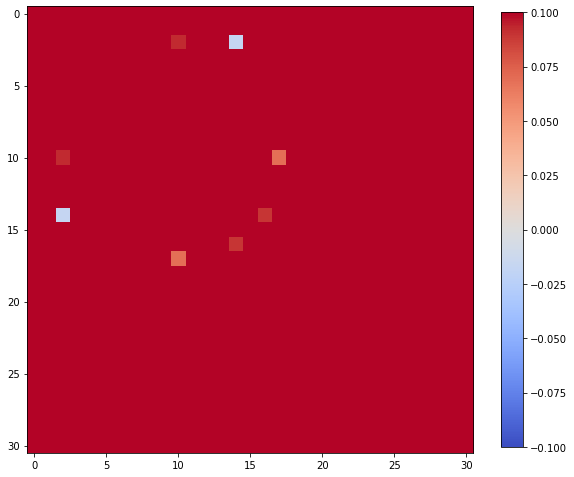

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
im = ax.imshow(iss, cmap='coolwarm', vmin=-0.1, vmax=0.1)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.8)

In [13]:
(iss[0:30,0:30].sum(axis=1) - 1)/29

array([0.35882321, 0.31555923, 0.21484233, 0.30328539, 0.3278989 ,
       0.26489333, 0.31162079, 0.28583923, 0.26509024, 0.28523821,
       0.19949855, 0.27718864, 0.33598162, 0.27805958, 0.22946056,
       0.28747677, 0.25789604, 0.23309217, 0.30898671, 0.28437755,
       0.23144276, 0.2153204 , 0.29183759, 0.30362506, 0.3507258 ,
       0.24724455, 0.24579767, 0.25097688, 0.28113723, 0.29638438])

In [11]:
pair_visual_iss = iss[np.tril_indices(30,-1)]

In [12]:
np.where(iss==np.max(pair_visual_iss))

(array([ 0, 12]), array([12,  0]))

In [10]:
np.argsort(iss[-1,:])

array([10, 14, 21,  2, 20, 17, 25, 26, 27,  8, 16,  5, 28,  9, 19, 11, 15,
        3, 13, 29, 18, 22, 23,  7,  4,  6,  1, 12,  0, 24, 30])

In [68]:
np.sort(iss[-1,:])

array([0.37221813, 0.42337663, 0.43611747, 0.43872842, 0.4542361 ,
       0.46282818, 0.4651248 , 0.47242596, 0.5009495 , 0.50470972,
       0.5070092 , 0.51423166, 0.52962342, 0.52984902, 0.5301051 ,
       0.54167592, 0.54222807, 0.55073404, 0.55923275, 0.56408277,
       0.56504905, 0.56802487, 0.57203783, 0.58886937, 0.59515771,
       0.5953371 , 0.61131442, 0.62195792, 0.64504706, 0.65338397,
       1.        ])